In [2]:
import numpy as np
import matplotlib.pyplot as plt
import msprime, tskit

In [4]:
import pandas as pd

In [3]:
n = 100
L = 16e6
r = 2e-8
N = 1.67e5

In [5]:
fourD_sites = pd.read_csv('../data/dmel-4Dsites.txt.gz', header=None, names=['chr', 'pos'], sep='\t')
start = int(1e6) + 1

In [6]:
positions = np.array(fourD_sites.pos[fourD_sites.chr == '2L'] - start)
positions = positions[np.logical_and(positions>=0, positions<L)]

In [7]:
print(positions)

[   13961    13970    13973 ... 15993026 15993029 15993035]


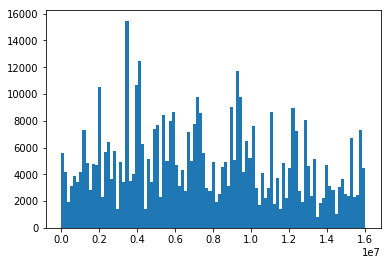

In [8]:
plt.hist(positions, bins=np.linspace(0,L,100));

In [93]:
def sites(self, sample_set, site_positions):
    '''
    Computes the expected *derived* (unfolded) site frequency spectrum,
    based on tree lengths, separately in each window.

    :param list sample_set: A list of IDs of samples of length n.
    :param iterable windows: The breakpoints of the windows (including start
        and end, so has one more entry than number of windows).
    :return: A list of lists of length n, one for each window, whose kth
        entry gives the total length of any branches in the marginal trees
        over that window that are ancestral to exactly k of the samples,
        divided by the length of the window.
    '''
    if ((not isinstance(sample_set, list)) or
       len(sample_set) != len(set(sample_set))):
        raise ValueError(
            "elements of sample_sets must be lists without repeated elements.")
    if len(sample_set) == 0:
        raise ValueError("elements of sample_sets cannot be empty.")
    for u in sample_set:
        if not self.tree_sequence.node(u).is_sample():
            raise ValueError("Not all elements of sample_sets are samples.")
            
    num_sites = len(site_positions) 
    
    for k in range(num_sites-1):
        if site_positions[k + 1] <= site_positions[k]:
            raise ValueError("Site positions must be increasing.")
    n_out = len(sample_set)
    S = [[0.0 for j in range(n_out)] for _ in range(num_sites)]
    L = [0.0 for j in range(n_out)]
    N = self.tree_sequence.num_nodes
    X = [int(u in sample_set) for u in range(N)]
    # we will essentially construct the tree
    pi = [-1 for j in range(N)]
    node_time = [self.tree_sequence.node(u).time for u in range(N)]
    # keep track of where we are for the windows
    chrom_pos = 0.0
    # index of *left-hand* end of the current window
    site_num = 0
    for interval, records_out, records_in in self.tree_sequence.edge_diffs():
        length = interval[1] - interval[0]
        for sign, records in ((-1, records_out), (+1, records_in)):
            for edge in records:
                dx = 0
                if sign == +1:
                    pi[edge.child] = edge.parent
                dx += sign * X[edge.child]
                dt = (node_time[pi[edge.child]] - node_time[edge.child])
                if X[edge.child] > 0:
                    L[X[edge.child] - 1] += sign * dt
                if sign == -1:
                    pi[edge.child] = -1
                old_X = X[edge.parent]
                X[edge.parent] += dx
                if pi[edge.parent] != -1:
                    dt = (node_time[pi[edge.parent]] - node_time[edge.parent])
                    if X[edge.parent] > 0:
                        L[X[edge.parent] - 1] += dt
                    if old_X > 0:
                        L[old_X - 1] -= dt
                # propagate change up the tree
                u = pi[edge.parent]
                if u != -1:
                    next_u = pi[u]
                    while u != -1:
                        old_X = X[u]
                        X[u] += dx
                        # need to update X for the root,
                        # but the root does not have a branch length
                        if next_u != -1:
                            dt = (node_time[pi[u]] - node_time[u])
                            if X[u] > 0:
                                L[X[u] - 1] += dt
                            if old_X > 0:
                                L[old_X - 1] -= dt
                        u = next_u
                        next_u = pi[next_u]
        while chrom_pos + length >= site_positions[site_num]:
            for j in range(n_out):
                S[site_num][j] += L[j]
            site_num += 1
            if site_num == num_sites:
                return S
        else:
            chrom_pos += length
    return S

In [129]:
np.random.seed(100)
length = int(1e6)
sim = msprime.simulate(model=msprime.StandardCoalescent(), Ne=1/2, recombination_rate=0.067, length=length, sample_size=n)

In [130]:
sample_set = list(range(n))
windows = np.arange(0, length+1)
calculator = tskit.BranchLengthStatCalculator(sim)

In [131]:
mytimes = np.array(sites(calculator, sample_set, positions[positions<length]))

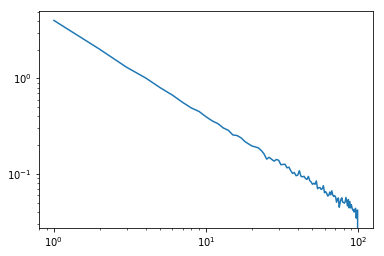

In [132]:
plt.loglog(np.arange(1, n+1), np.mean(mytimes,axis=0))

In [135]:
print('Size of sfs array:', mytimes.nbytes / 1e6, 'MB')

Size of sfs array: 18.8168 MB


In [136]:
mytimes.shape

(23521, 100)

## Check saving and loading

In [146]:
np.save('test_save', mytimes)
np.savez_compressed('test_save', times=mytimes)

In [147]:
X = np.load('test_save.npy')
print(np.all(np.isclose(X, mytimes)))

True


In [148]:
with np.load('test_save.npz') as data:
    X = data['times']
print(np.all(np.isclose(X, mytimes)))

True


In [154]:
import os
print("Uncompressed size:\t{}\tMB".format(os.path.getsize('test_save.npy')//1e6))
print("Compressed size:\t{}\tMB".format(os.path.getsize('test_save.npz')//1e6))

Uncompressed size:	18.0	MB
Compressed size:	3.0	MB


## Old checks

In [102]:
times = np.array(calculator.site_frequency_spectrum(sample_set, windows=windows))

In [107]:
times4d = times[positions[positions<length]]

In [125]:
np.mean(np.isclose(mytimes, times4d))

0.905920666013712

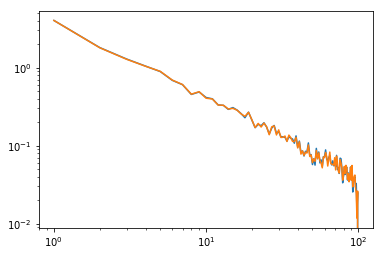

In [128]:
plt.loglog(np.arange(1, n+1), np.mean(mytimes,axis=0))
plt.loglog(np.arange(1, n+1), np.mean(times4d,axis=0))